# Emotion Detection with Computer Vision

## Overview
This project proposes a Facial Emotion Classifier that compares multiple computer vision methods and experimental setups to determine the best approach. Using the Kaggle Face Expression Recognition dataset, we will implement three main classifier families of increasing complexity: a baseline single-layer network (Random Forest) on extracted features, a deep ResNet-style CNN, and a Vision Transformer–based model. For each model, we will explore data augmentation with GANs and systematic hyperparameter tuning with Python tooling, to study their impact on accuracy and generalization. We will plot and analyze our results and display our model's accuracy after each trial to best showcase the findings of our experimentation.

## Defining Standard Architecture

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
# Initialize Data
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

Using Colab cache for faster access to the 'face-expression-recognition-dataset' dataset.


In [4]:


data_root = os.path.join(path, "images")
train_dir = os.path.join(data_root, "train")
val_dir = os.path.join(data_root, "validation")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_set = datasets.ImageFolder(root=train_dir, transform=transform)
test_set = datasets.ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Classes:", train_set.classes)
print("Train size:", len(train_set))
print("Test size:", len(test_set))

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Train size: 28821
Test size: 7066


In [5]:
def plot_curves(loss, training, test, epochs):
    epochs_axis = range(1, epochs + 1)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].plot(epochs_axis, loss, label='Training Loss')
    axes[0].set_title('Training Loss per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs_axis, training, label='Training Accuracy')
    axes[1].set_title('Training Accuracy per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(epochs_axis, test, label='Test Accuracy')
    axes[2].set_title('Test Accuracy per Epoch')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [6]:
def train_model(net, trainloader, testloader, learning_rate = 0.001, criterion = nn.CrossEntropyLoss()):
    epochs = 30
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    learning_rate_optimizer = optim.lr_scheduler.StepLR(optimizer, step_size=10,gamma=0.1)

    device = next(net.parameters()).device

    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        batch = 0

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            if isinstance(criterion, nn.MSELoss):
                targets = F.one_hot(labels, num_classes=10).float()
                loss = criterion(outputs, targets)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            batch += 1

            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        average_loss = running_loss / batch
        train_acc = correct_train / total_train

        print(f'Epoch: {epoch+1}/{epochs} --- Train Loss: {average_loss} --- Training Accuracy: {train_acc}')

        correct_test = 0
        total_test = 0

        net.eval()

        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = correct_test / total_test

        train_losses.append(average_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        learning_rate_optimizer.step()

    plot_curves(train_losses, train_accs, test_accs, epochs)

In [45]:
def imshow(img, ax):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

def run_predictions(model, dataloader, num_images=5):
    device = next(model.parameters()).device

    num_images = min(num_images, len(test_set))

    indices = np.random.choice(len(test_set), size=num_images, replace=False)

    images_list = []
    labels_list = []

    for idx in indices:
        img, label = test_set[idx]
        images_list.append(img)
        labels_list.append(label)

    images = torch.stack(images_list)
    labels = torch.tensor(labels_list)

    # Forward pass
    with torch.no_grad():
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

    correct = (preds == labels).sum().item()
    accuracy = correct / num_images * 100

    # Plot
    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))
    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        ax = axes[i]
        imshow(images[i], ax)
        pred_label = train_set.classes[preds[i].item()]
        true_label = train_set.classes[labels[i].item()]
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")

    plt.tight_layout()
    plt.show()

    print(f"Correct on this sample: {correct}/{num_images} = {accuracy:.1f}%")

## Single Layer Network

In [8]:
class Single_Layer_Net(nn.Module):
    def __init__(self):
        super(Single_Layer_Net, self).__init__()
        self.fc = nn.Linear(3 * 48 * 48, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 48 * 48)
        x = self.fc(x)
        return x

net = Single_Layer_Net()

Epoch: 1/30 --- Train Loss: 1.864098206327654 --- Training Accuracy: 0.30953124457860587
Epoch: 2/30 --- Train Loss: 1.7856163436716253 --- Training Accuracy: 0.33943999167273864
Epoch: 3/30 --- Train Loss: 1.7625738813184582 --- Training Accuracy: 0.35272891294542175
Epoch: 4/30 --- Train Loss: 1.7411841175244283 --- Training Accuracy: 0.35064709760244267
Epoch: 5/30 --- Train Loss: 1.7323026416571337 --- Training Accuracy: 0.3533187606259325
Epoch: 6/30 --- Train Loss: 1.718166606389234 --- Training Accuracy: 0.3595989035772527
Epoch: 7/30 --- Train Loss: 1.7064514220950344 --- Training Accuracy: 0.36175011276499774
Epoch: 8/30 --- Train Loss: 1.6940837527590158 --- Training Accuracy: 0.36848131570729675
Epoch: 9/30 --- Train Loss: 1.6881132921464164 --- Training Accuracy: 0.3658790465285729
Epoch: 10/30 --- Train Loss: 1.6770466748468098 --- Training Accuracy: 0.36969570799070123
Epoch: 11/30 --- Train Loss: 1.6295756746554322 --- Training Accuracy: 0.3907220429547899
Epoch: 12/30 -

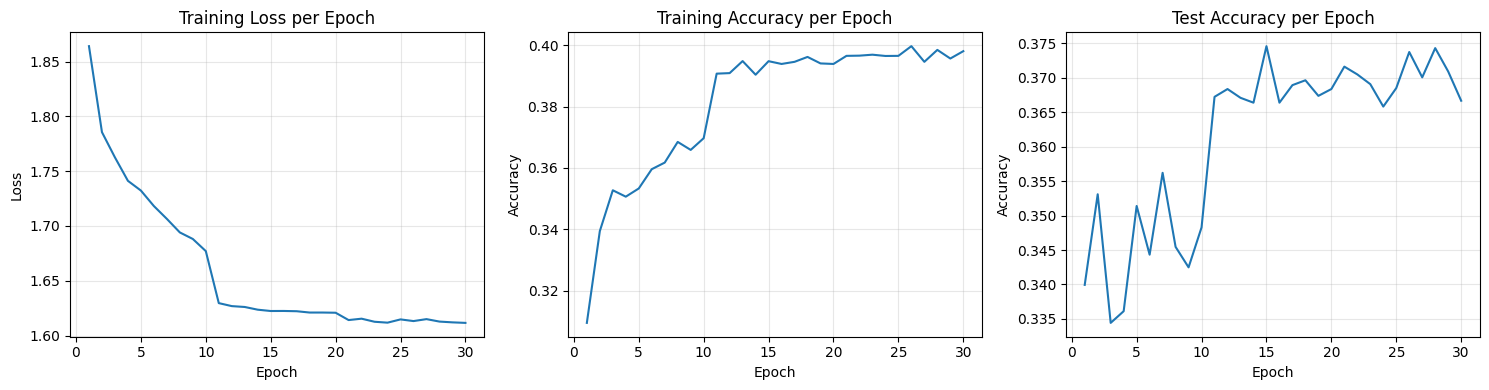

In [9]:
train_model(net, train_loader, test_loader)

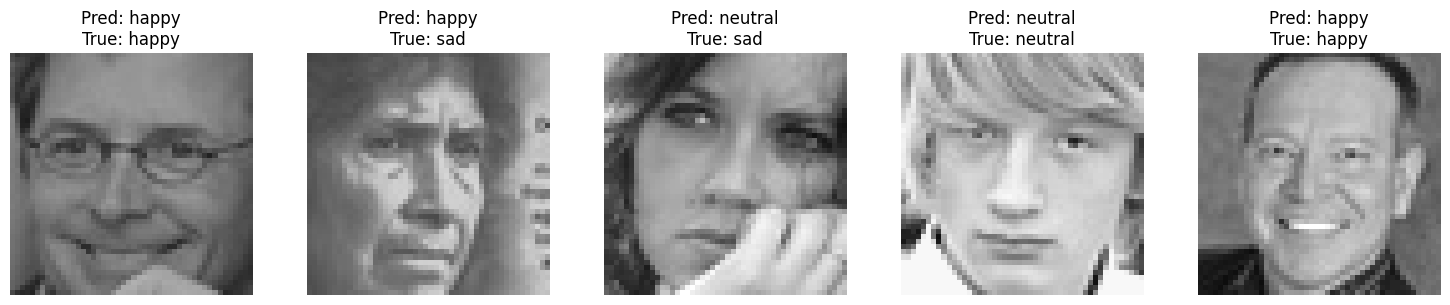

Correct on this sample: 3/5 = 60.0%


In [55]:
run_predictions(net, test_loader, num_images=5)

### Findings
Both training and testing accuracy were pretty low when using a single layer network. Training accuracy peaked around 42% while testing accuracy fluctuated between about 24% and 37%. Overall, this model was okay at best as seen by the example predictions. The model usually predicted about 2 of the images correctly in a set of 5, sometimes hitting 3 and going down to 1. This result is okay but makes sense given the simplicity of the architecture.

### Adding Data Augmentation

In [44]:
transform = transforms.Compose([
  transforms.RandomHorizontalFlip(),
  transforms.RandomResizedCrop(size=48, scale=(0.9, 1.0)),
  transforms.RandomRotation(12),
  transforms.GaussianBlur(kernel_size=3),
  transforms.Grayscale(num_output_channels=1),
  transforms.ToTensor(),
  transforms.Normalize([0.5], [0.5])
  ])

In [ ]:
train_model(net, train_loader, test_loader)

In [ ]:
run_predictions(net, test_loader, num_images=5)

## ResNet

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, input_channels, output_channels, stride=1):
    super(ResidualBlock, self).__init__()
    # 2 convolutional layers in each residual block
    self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(output_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(output_channels)
    # setting up skip/shortcut layer
    self.shortcut = nn.Sequential()
    if stride != 1 or input_channels != output_channels:
      self.shortcut = nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=stride, bias=False))

  def forward(self, x):
    # x here is input tensor
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out = out + self.shortcut(x)
    out = self.relu(out)
    return out

In [ ]:
class ResNet18(nn.Module):
  def __init__(self, num_classes=10, dropout_rate=0.3):
    super(ResNet18, self).__init__()
    self.input_channels = 64
    self.conv_1_x = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.conv_2_x = self.make_layer(ResidualBlock, 64, 2, 1)
    self.conv_3_x = self.make_layer(ResidualBlock, 128, 2, 2)
    self.conv_4_x = self.make_layer(ResidualBlock, 256, 2, 2)
    self.conv_5_x = self.make_layer(ResidualBlock, 512, 2, 2)
    self.bn_1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.average_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout_layer = nn.Dropout(dropout_rate)
    self.fc_layer = nn.Linear(512, num_classes)

  def make_layer(self, block, output_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.input_channels, output_channels, stride))
      self.input_channels = output_channels
    return nn.Sequential(*layers)

  def forward(self, x):
    out = self.conv_1_x(x)
    out = self.bn_1(out)
    out = self.relu(out)
    # going through residual blocks of convolutional layers
    out = self.conv_2_x(out)
    out = self.conv_3_x(out)
    out = self.conv_4_x(out)
    out = self.conv_5_x(out)
    # average pooling layer for image condensation
    out = self.average_pool(out)
    out = out.view(out.size(0), -1)
    out = self.dropout_layer(out)
    # fully connected layer to get ouputs
    out = self.fc_layer(out)
    return out

model = ResNet18(7)

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Move the network to the device
model.to(device)

Using Apple Silicon GPU (MPS)


ResNet18(
  (conv_1_x): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv_2_x): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Epoch: 1/30 --- Train Loss: 1.75308519985089 --- Training Accuracy: 0.2816696159050692
Epoch: 2/30 --- Train Loss: 1.4464360573339357 --- Training Accuracy: 0.4383956143090108
Epoch: 3/30 --- Train Loss: 1.2801104160211567 --- Training Accuracy: 0.5107733943999168
Epoch: 4/30 --- Train Loss: 1.1700183030242666 --- Training Accuracy: 0.5518892474237536
Epoch: 5/30 --- Train Loss: 1.0842637649660893 --- Training Accuracy: 0.5863432913500572
Epoch: 6/30 --- Train Loss: 1.0180119883987697 --- Training Accuracy: 0.6159397661427432
Epoch: 7/30 --- Train Loss: 0.951642440057911 --- Training Accuracy: 0.6404357933451302
Epoch: 8/30 --- Train Loss: 0.8752220699898156 --- Training Accuracy: 0.6764858957010513
Epoch: 9/30 --- Train Loss: 0.816373720665993 --- Training Accuracy: 0.6967142014503314
Epoch: 10/30 --- Train Loss: 0.7431570092616747 --- Training Accuracy: 0.7298844592484647
Epoch: 11/30 --- Train Loss: 0.5247569146943991 --- Training Accuracy: 0.8243988758197148
Epoch: 12/30 --- Train 

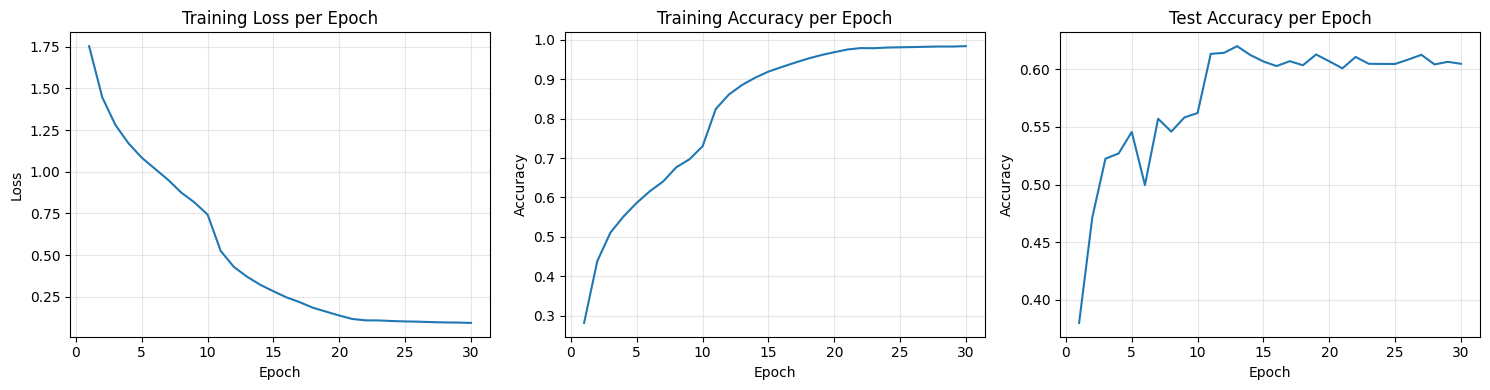

In [ ]:
train_model(model, train_loader, test_loader)